In [3]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

In [29]:
rng = Random.default_rng();

# # graph parameters
# n = 100
# p = 0.1
# eta = 0.6

# # planted ranking score
# planted_score = randperm(rng,n)
# # planted_score = 1:n
# planted_ranking = ranking_from_score(planted_score)

# #  meta_g = gen_graph_mun_basic( n, p, eta)
# #meta_g = gen_graph_ero_basic( n, p, eta)

# # graph model
# type = "MUN" 

# if type=="MUN"
#     meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
# elseif type=="ERO"
#     meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
# end

# planted ranking score
n = 100

planted_score = randperm(rng,n)
planted_ranking = ranking_from_score(planted_score)

eta = 0.5
noise = 0.6
p_in = 0.8
p_out = 0.1
meta_g = ero_mun_sbm(rng,n,p_in,p_out,eta,noise;planted_score)


B = magnetic_incidence(meta_g)
L_mag = B * B'
ranking_sync = syncrank(L_mag, meta_g; singular=true)

oriented=true
phases=false


## Standard Least Squares and Sync-Rank

# std edge-vertex incidence matrix
B_0 = -real.(magnetic_incidence_matrix(meta_g; oriented, phases))
L = B_0 * B_0'

# store the comparisons in array
a = zeros(ne(meta_g),1)
id = 0
for e in edges(meta_g)
    id +=1
    a[id] = get_edge_prop(meta_g, e, :angle, oriented)
end

score_LS = L\(B_0*a)

ranking_LS = ranking_from_score(score_LS)

tau_LS = corkendall(ranking_LS,planted_ranking)
tau_sync = corkendall(ranking_sync,planted_ranking)
println(tau_LS)
println(tau_sync)


0.743030303030303
0.8703030303030304


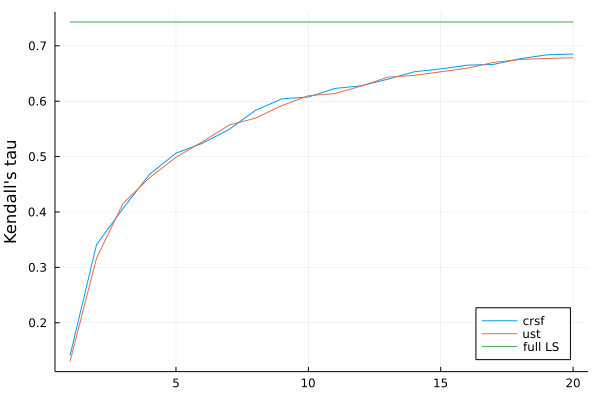

In [31]:
n_batch_tot = 20

q = 0
weighted = false
absorbing_node = true
ust = true

n_rep = 50

tau_crsf = zeros(n_batch_tot,1)
tau_tree = zeros(n_batch_tot,1)

tau_crsf_std = zeros(n_batch_tot,1)
tau_tree_std = zeros(n_batch_tot,1)


for nb_batch = 1:n_batch_tot
    tau_crsf_tp = zeros(n_rep,1)
    tau_tree_tp = zeros(n_rep,1)
    for i_rep = 1:n_rep

        ## CRSF
        edge_list = []
        for _ in 1:nb_batch
            mtsf = multi_type_spanning_forest(rng, meta_g, q)
            ind_e = mtsf_edge_indices(mtsf, meta_g)
            push!(edge_list, ind_e)
        end
        flt_edge_list = collect(Iterators.flatten(edge_list))
        # correct here
        flt_edge_list = unique(flt_edge_list);

        L_crsf = B_0[:,flt_edge_list] * B_0[:,flt_edge_list]' + 1e-14*I
        score_crsf = L_crsf\(B_0[:,flt_edge_list]*a[flt_edge_list])

        ranking_crsf = ranking_from_score(score_crsf)

        tau_crsf_tp[i_rep] = corkendall(ranking_crsf,planted_ranking)

        ## UST
        edge_list = []
        for _ in 1:nb_batch
            tree = multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)
            ind_e = mtsf_edge_indices(tree, meta_g)
            push!(edge_list, ind_e)
        end
        flt_edge_list = collect(Iterators.flatten(edge_list))
        # correct here
        flt_edge_list = unique(flt_edge_list);

        L_tree = B_0[:,flt_edge_list] * B_0[:,flt_edge_list]' + 1e-14*I
        score_tree = L_tree\(B_0[:,flt_edge_list]*a[flt_edge_list])

        ranking_tree = ranking_from_score(score_tree)

        tau_tree_tp[i_rep] = corkendall(ranking_tree,planted_ranking)
    end
    tau_crsf[nb_batch] = mean(tau_crsf_tp)
    tau_tree[nb_batch] = mean(tau_tree_tp)

    tau_crsf_std[nb_batch] = std(tau_crsf_tp)
    tau_tree_std[nb_batch] = std(tau_tree_tp)
end

plot(1:n_batch_tot,tau_crsf,labels="crsf")
plot!(1:n_batch_tot,tau_tree,labels="ust")
plot!(1:n_batch_tot,tau_LS*ones(n_batch_tot,1),labels="full LS",legend=:bottomright)


ylabel!("Kendall's tau")

